#### Nathan 2021 PBMC abridged QC

**Objective**: Run QC steps without normalisation/UMAP for Nathan 2021 data

**Developed by**: Mairi McClean

**Affiliation**: Institute of Computational Biology, Helmholtz Zentrum Munich

**v230306**

In [1]:
import os 
os.write(1, b"text\n")


text


5

### Load required modules

In [2]:
import anndata
import logging
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sb
import scrublet as scr
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import rcParams

In [3]:
sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.set_figure_params(dpi = 160, color_map = 'RdPu', dpi_save = 180, vector_friendly = True, format = 'svg')


-----
anndata     0.8.0
scanpy      1.9.2
-----
PIL                 8.2.0
anyio               NA
appnope             0.1.3
arrow               1.2.3
asttokens           NA
attr                22.2.0
babel               2.12.1
backcall            0.2.0
beta_ufunc          NA
binom_ufunc         NA
brotli              NA
certifi             2022.12.07
cffi                1.15.1
charset_normalizer  2.1.1
colorama            0.4.6
comm                0.1.2
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.2
debugpy             1.6.6
decorator           5.1.1
executing           1.2.0
fastjsonschema      NA
fqdn                NA
h5py                3.8.0
hypergeom_ufunc     NA
idna                3.4
igraph              0.10.4
ipykernel           6.21.2
ipython_genutils    0.2.0
isoduration         NA
jedi                0.18.2
jinja2              3.1.2
joblib              1.2.0
json5               NA
jsonpointer         2.3
jsonschema          4.17.3
jupyter_events

### Read datasets

In [4]:
adata = sc.read_h5ad('/Volumes/LaCie/data_lake/Mairi_example/INBOX/sc_downloads/nathan_2021_from_carlos/Lung_TB_T_Cells_CITESEQ_RNA.h5ad')
adata

AnnData object with n_obs × n_vars = 500089 × 33538
    obs: 'cell_id', 'nUMI', 'nGene', 'percent_mito', 'batch', 'TB_status', 'UMAP_1', 'UMAP_2', 'cluster_name', 'cluster_ids', 'donor'

In [5]:
adata.var_names_make_unique()
sample_object = adata.copy()
sample_object

AnnData object with n_obs × n_vars = 500089 × 33538
    obs: 'cell_id', 'nUMI', 'nGene', 'percent_mito', 'batch', 'TB_status', 'UMAP_1', 'UMAP_2', 'cluster_name', 'cluster_ids', 'donor'

- Sort columns in .var df


> I need to modify the original .var object, which is NOT a numpy array. Therefore '.view' will not work
> I need to make a new column in the .var object called "gene_ids", or rename the index column

In [6]:
sample_object.shape


(500089, 33538)

In [7]:
sample_object.var.shape

(33538, 0)

In [8]:
sample_object.var_names

Index(['MIR1302-2HG', 'FAM138A', 'OR4F5', 'AL627309.1', 'AL627309.3',
       'AL627309.2', 'AL627309.4', 'AL732372.1', 'OR4F29', 'AC114498.1',
       ...
       'AC007325.2', 'BX072566.1', 'AL354822.1', 'AC023491.2', 'AC004556.1',
       'AC233755.2', 'AC233755.1', 'AC240274.1', 'AC213203.1', 'FAM231C'],
      dtype='object', length=33538)

In [9]:
# Renanme index column of the .var object
sample_object.var = sample_object.var.rename_axis('gene_name')

In [10]:
sample_object.var

""
gene_name
MIR1302-2HG
FAM138A
OR4F5
AL627309.1
AL627309.3
...
AC233755.2
AC233755.1
AC240274.1


In [11]:
# Make a copy of the information in the index column and add it to a new column called 'gene_ids'

sample_object.var['gene_ids'] = sample_object.var.index.copy()

In [12]:
print(sample_object.var.head())

                gene_ids
gene_name               
MIR1302-2HG  MIR1302-2HG
FAM138A          FAM138A
OR4F5              OR4F5
AL627309.1    AL627309.1
AL627309.3    AL627309.3


### Filter cells with less than 200 genes

In [13]:
sc.pp.filter_cells(sample_object, min_genes = 200)
print(sample_object.n_obs, sample_object.n_vars)

500089 33538


### Compute QC stats

In [14]:
sample_object.shape

(500089, 33538)

In [15]:
sample_object.var['mt'] = sample_object.var_names.str.startswith('MT-') 
sample_object.var['ribo'] = sample_object.var_names.str.startswith(("RPS","RPL"))
sample_object.var

,gene_ids,mt,ribo
gene_name,,,
MIR1302-2HG,MIR1302-2HG,False,False
FAM138A,FAM138A,False,False
OR4F5,OR4F5,False,False
AL627309.1,AL627309.1,False,False
AL627309.3,AL627309.3,False,False
...,...,...,...
AC233755.2,AC233755.2,False,False
AC233755.1,AC233755.1,False,False
AC240274.1,AC240274.1,False,False


In [16]:
# Check if a certain value is contained within a df

'True' in sample_object.var.ribo.values

/var/folders/g6/vfgrx_y95ml0h2lsgfx4jg6jwvdsz3/T/ipykernel_6035/2783756595.py:3: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  'True' in sample_object.var.ribo.values


False

In [17]:
'True' in sample_object.var.mt.values

/var/folders/g6/vfgrx_y95ml0h2lsgfx4jg6jwvdsz3/T/ipykernel_6035/2307658904.py:1: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  'True' in sample_object.var.mt.values


False

- Manual annotation of mito genes

> Is this entirely necessaryif we perform the previous ".startswith"? 
>> I thought yes, because perhaps gene naming convention would not be followed, especially for mitochonrial genes. However, maybe this is less relevant for ribosomal genes?

In [18]:
mito_genes = ['RNR1', 'TV', 'TY', 'ATP8', 'ATP6', 'CO1', 'CO2', 'CO3', 'CYB', 'ND1', 'ND2', 'ND3', 'ND4L', 'ND4', 'ND5', 'ND6', 'RNR2', 'TA', 'TR', 'TN', 'TD', 'TC', 'TE', 'TQ', 'TG', 'TH', 'TI', 'TL1', 'TL2', 'TK', 'TM', 'TF', 'TP', 'TS1', 'TS2', 'TT', 'TW', 'TY', 'TV', 'RNR1']
print(mito_genes)

['RNR1', 'TV', 'TY', 'ATP8', 'ATP6', 'CO1', 'CO2', 'CO3', 'CYB', 'ND1', 'ND2', 'ND3', 'ND4L', 'ND4', 'ND5', 'ND6', 'RNR2', 'TA', 'TR', 'TN', 'TD', 'TC', 'TE', 'TQ', 'TG', 'TH', 'TI', 'TL1', 'TL2', 'TK', 'TM', 'TF', 'TP', 'TS1', 'TS2', 'TT', 'TW', 'TY', 'TV', 'RNR1']


In [19]:
# Make list into df
mito_genes_df = pd.DataFrame(mito_genes)
print(mito_genes_df)

       0
0   RNR1
1     TV
2     TY
3   ATP8
4   ATP6
5    CO1
6    CO2
7    CO3
8    CYB
9    ND1
10   ND2
11   ND3
12  ND4L
13   ND4
14   ND5
15   ND6
16  RNR2
17    TA
18    TR
19    TN
20    TD
21    TC
22    TE
23    TQ
24    TG
25    TH
26    TI
27   TL1
28   TL2
29    TK
30    TM
31    TF
32    TP
33   TS1
34   TS2
35    TT
36    TW
37    TY
38    TV
39  RNR1


In [20]:
# This makes a new column in "adata.var" called "mito" that will print "true/false" if the same information in gene_id is found in the mito_genes dataframe.

sample_object.var['mito'] = sample_object.var.gene_ids.isin(mito_genes_df[0].values)

In [27]:
sample_object.var

,gene_ids,mt,ribo,mito
gene_name,,,,
MIR1302-2HG,MIR1302-2HG,False,False,False
FAM138A,FAM138A,False,False,False
OR4F5,OR4F5,False,False,False
AL627309.1,AL627309.1,False,False,False
AL627309.3,AL627309.3,False,False,False
...,...,...,...,...
AC233755.2,AC233755.2,False,False,False
AC233755.1,AC233755.1,False,False,False
AC240274.1,AC240274.1,False,False,False


In [28]:
# Check if there is a difference in the response between autoamted and manual annotation of mito genes

'True' in sample_object.var.mito.values

/var/folders/g6/vfgrx_y95ml0h2lsgfx4jg6jwvdsz3/T/ipykernel_6035/224783437.py:3: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  'True' in sample_object.var.mito.values


False

In [29]:
sc.pp.calculate_qc_metrics(sample_object, qc_vars = ['mt','ribo'], percent_top = None, log1p = False, inplace = True)

In [30]:
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
# add the total counts per cell as observations-annotation to adata

mito_genes = sample_object.var_names.str.startswith('MT-')
sample_object.obs['percent_mt2'] = np.sum(
    sample_object[:, mito_genes].X, axis = 1).A1 / np.sum(sample_object.X, axis = 1).A1
sample_object.obs['n_counts'] = sample_object.X.sum(axis = 1).A1


In [31]:
sample_object

AnnData object with n_obs × n_vars = 500089 × 33538
    obs: 'cell_id', 'nUMI', 'nGene', 'percent_mito', 'batch', 'TB_status', 'UMAP_1', 'UMAP_2', 'cluster_name', 'cluster_ids', 'donor', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts'
    var: 'gene_ids', 'mt', 'ribo', 'mito', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

### Visualise QC metrics

In [32]:
sample_object.var_names

Index(['MIR1302-2HG', 'FAM138A', 'OR4F5', 'AL627309.1', 'AL627309.3',
       'AL627309.2', 'AL627309.4', 'AL732372.1', 'OR4F29', 'AC114498.1',
       ...
       'AC007325.2', 'BX072566.1', 'AL354822.1', 'AC023491.2', 'AC004556.1',
       'AC233755.2', 'AC233755.1', 'AC240274.1', 'AC213203.1', 'FAM231C'],
      dtype='object', name='gene_name', length=33538)

In [34]:
sample_object.obs.head

<bound method NDFrame.head of                     cell_id  nUMI  nGene  percent_mito  batch TB_status  \
0        AAACCCAAGGCCTAAG-1  6108   1557      0.055828      1      CASE   
1        AAACCCAAGGTTCTTG-1  7902   2149      0.083017      1      CASE   
2        AAACCCAAGTGCAGGT-1  5033   1788      0.129744      1      CASE   
3        AAACCCACAAGAGTAT-1  6574   1747      0.066930      1      CASE   
4        AAACCCACACACGGTC-1  6471   1872      0.047442      1      CASE   
...                     ...   ...    ...           ...    ...       ...   
500084  TTTGTTGTCCGCCTAT-46  1945    833      0.183033     46      CASE   
500085  TTTGTTGTCCTGGGTG-46  4534   1537      0.051610     46   CONTROL   
500086  TTTGTTGTCGATGGAG-46  3157   1013      0.081723     46      CASE   
500087  TTTGTTGTCGTTTACT-46  3675   1202      0.089252     46      CASE   
500088  TTTGTTGTCTCTTCAA-46  9072   2181      0.060185     46   CONTROL   

          UMAP_1    UMAP_2        cluster_name cluster_ids      donor

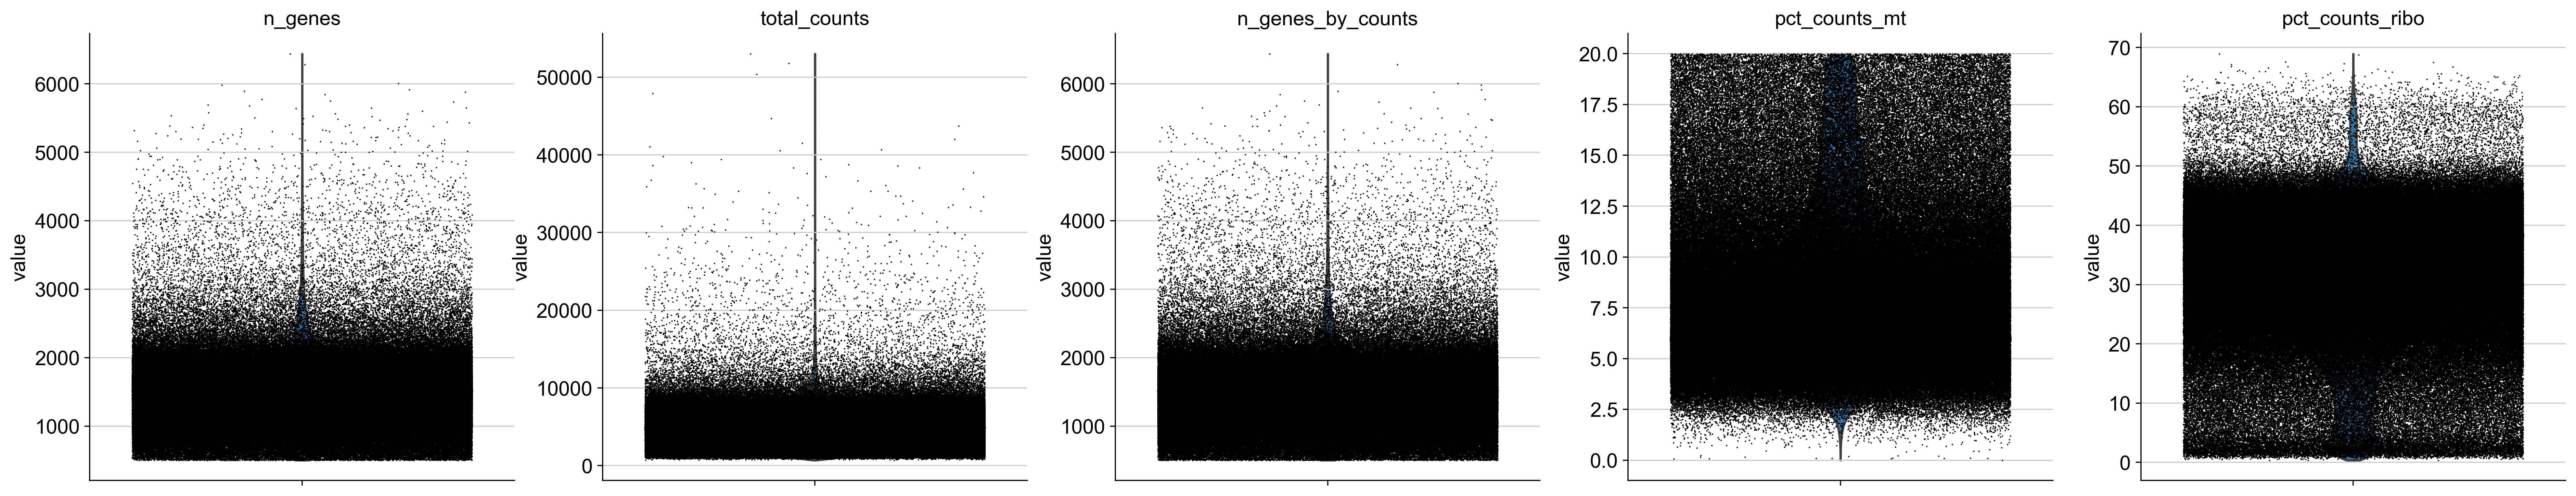

In [35]:
sc.pl.violin(sample_object, ['n_genes', 'total_counts', 'n_genes_by_counts', 'pct_counts_mt', 'pct_counts_ribo'],
             jitter=0.4, multi_panel=True)

- These panels would suggest that the data has been pre-filtered [see mt figure]
- There are also issues with the ribosomal genes, as apparently there are no ribosomal genes?

In [37]:
import seaborn as sns

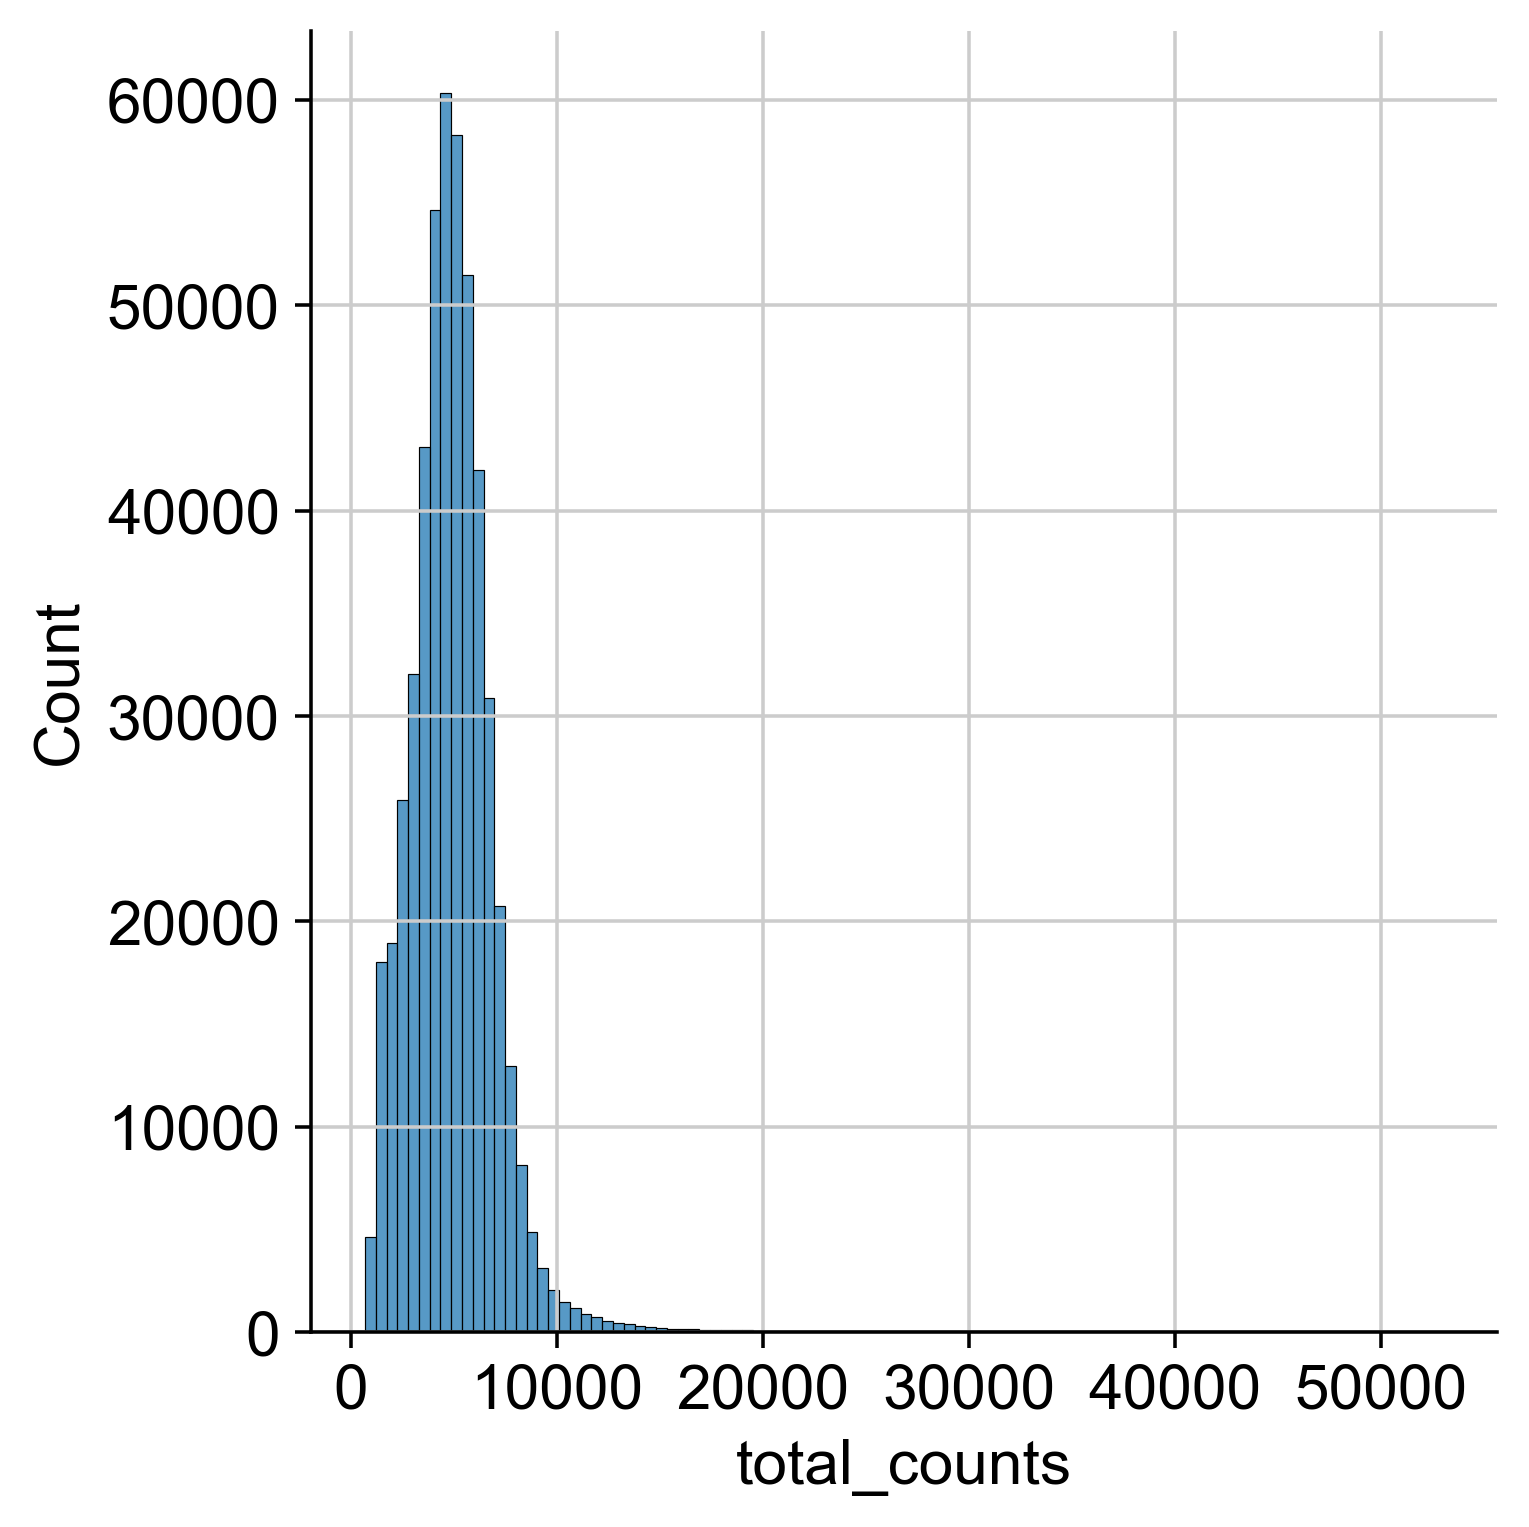

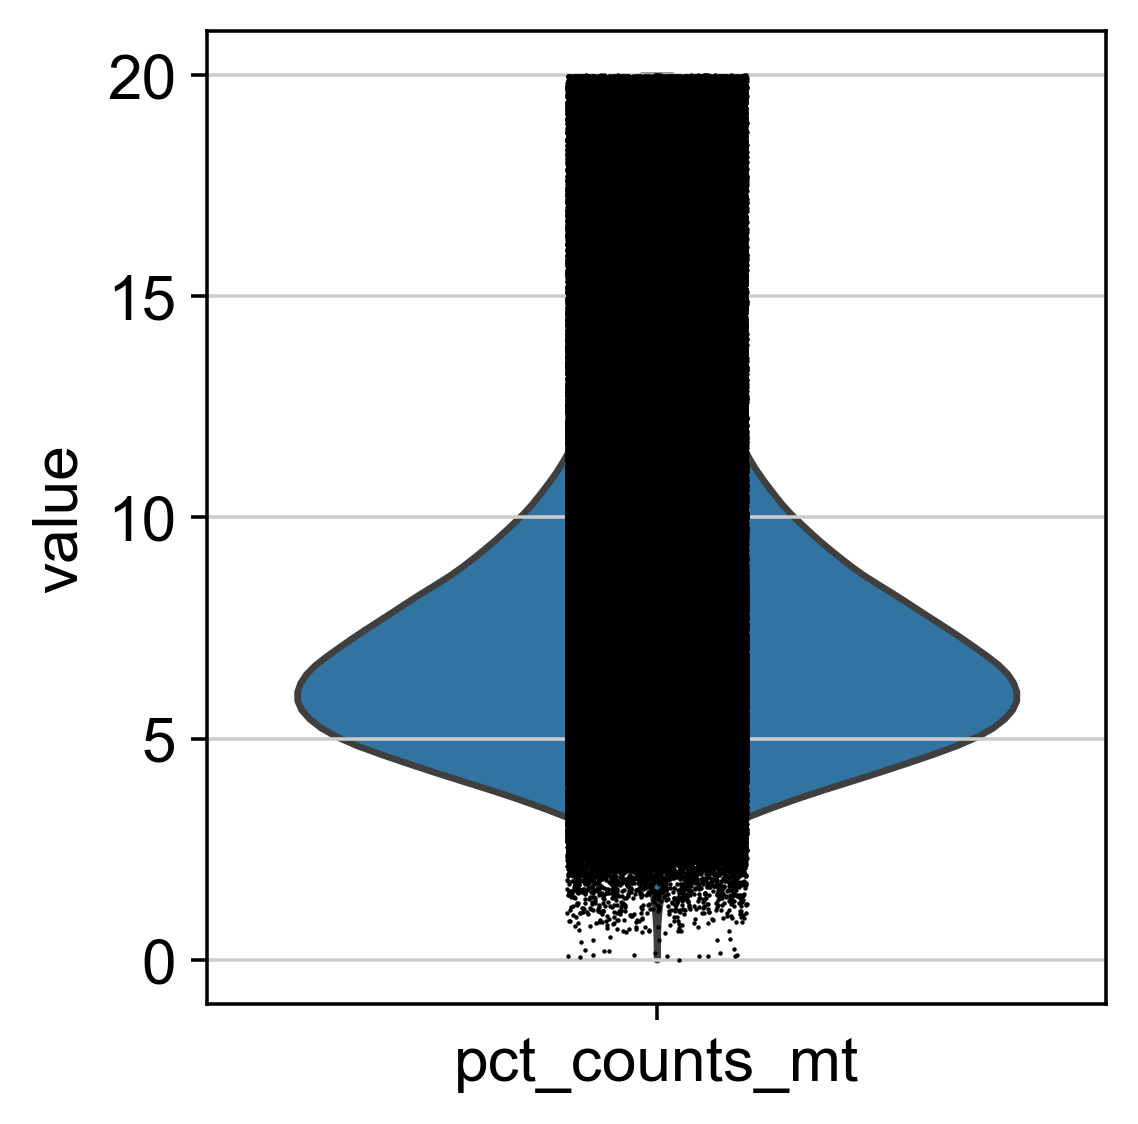

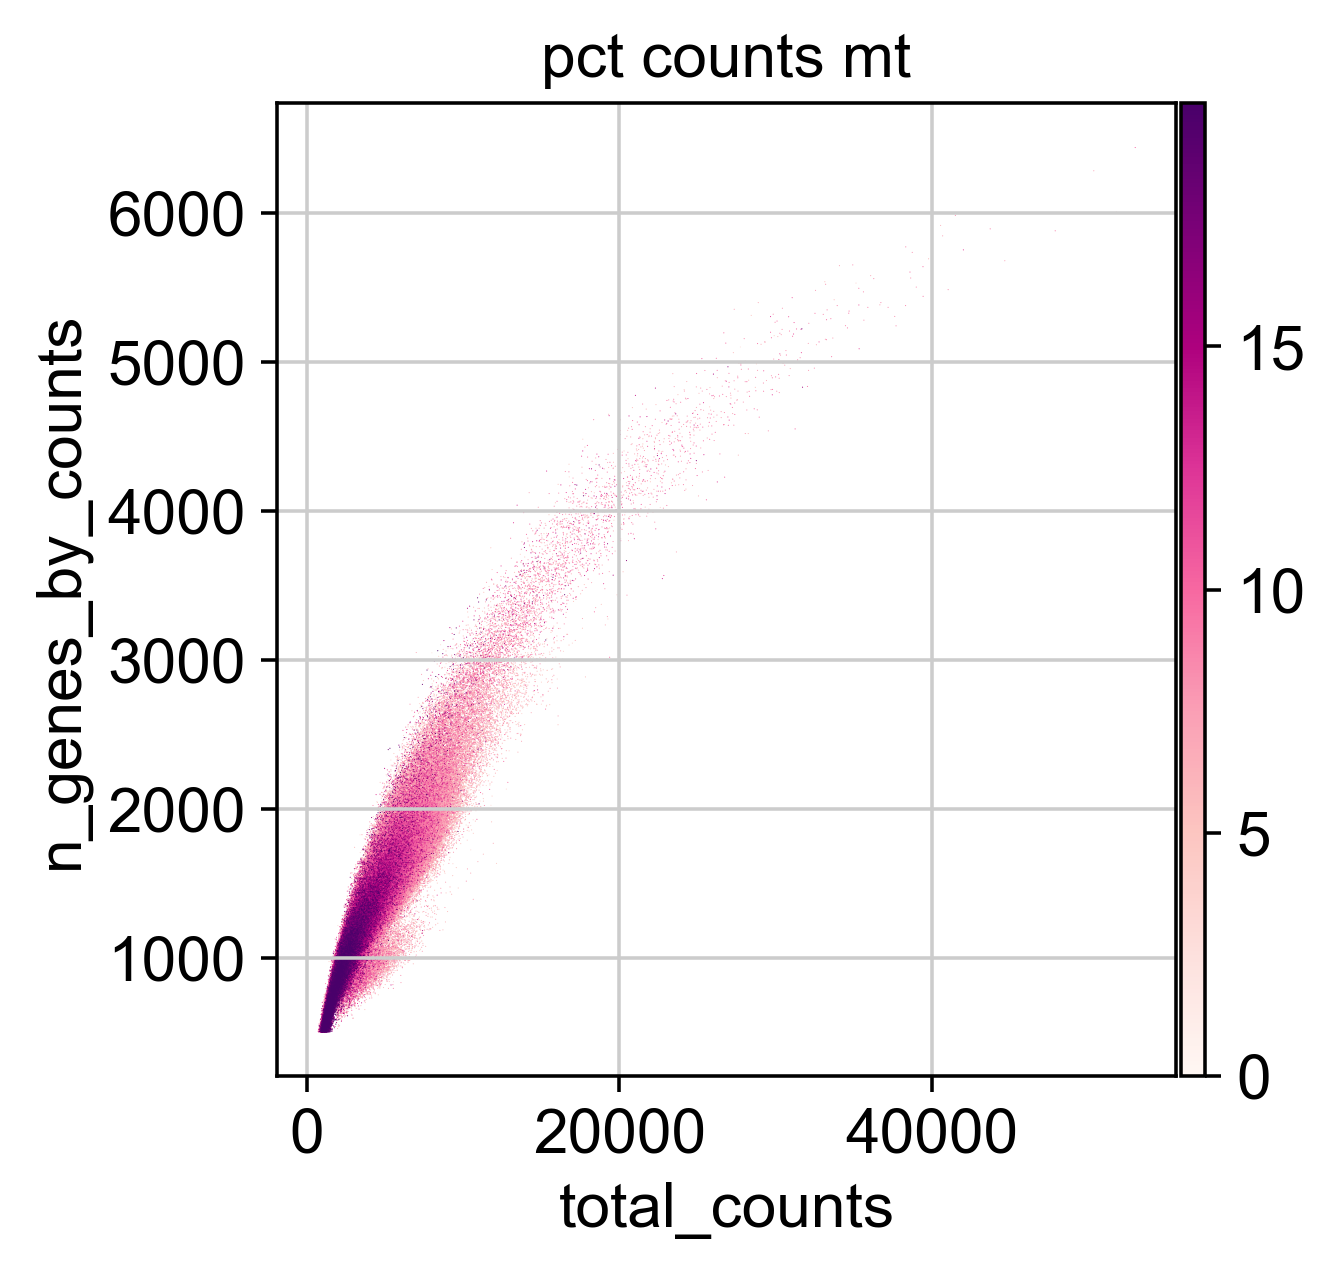

In [39]:
p1 = sns.displot(sample_object.obs["total_counts"], bins=100, kde=False)
# sc.pl.violin(adata, 'total_counts')
p2 = sc.pl.violin(sample_object, "pct_counts_mt")
p3 = sc.pl.scatter(sample_object, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [ ]:
# Organized by disease status as sample size is too large to do by sample

sc.pl.violin(sample_object, ['n_genes', 'total_counts', 'n_genes_by_counts', 'pct_counts_mt', 'pct_counts_ribo'],
             jitter = 0.2, groupby = 'TB_status', rotation = 45)

In [ ]:
sample_object.obs.value_counts('cluster_ids')

In [ ]:
sc.pl.scatter(sample_object, x = 'total_counts', y = 'pct_counts_mt', color = "TB_status")

In [ ]:
sc.pl.scatter(sample_object, x='total_counts', y='n_genes_by_counts', color = "TB_status")

### Add sample sex covariate

In [ ]:
annot = sc.queries.biomart_annotations(
        "hsapiens",
        ["ensembl_gene_id", "external_gene_name", "start_position", "end_position", "chromosome_name"],
    ).set_index("external_gene_name")

In [ ]:
annot.head()

In [ ]:
chrY_genes = sample_object.var_names.intersection(annot.index[annot.chromosome_name == "Y"])
chrY_genes

In [ ]:
sample_object.obs['percent_chrY'] = np.sum(
    sample_object[:, chrY_genes].X, axis = 1).A1 / np.sum(sample_object.X, axis = 1).A1 * 100

In [ ]:
sample_object.obs["XIST-counts"] = sample_object.X[:,sample_object.var_names.str.match('XIST')].toarray()

### Calculate cell cycle scores

In [ ]:
!if [ ! -f /Users/mairi.mcclean/cell_cycle_gene.txt ]; then curl -o /Users/mairi.mcclean/cell_cycle_gene.txt https://raw.githubusercontent.com/theislab/scanpy_usage/master/180209_cell_cycle/data/regev_lab_cell_cycle_genes.txt; fi

In [ ]:
cell_cycle_genes = [x.strip() for x in open('/Users/mairi.mcclean/data/qc_files/cell_cycle_gene.txt')]
print(len(cell_cycle_genes))

# Split into 2 lists
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]

cell_cycle_genes = [x for x in cell_cycle_genes if x in sample_object.var_names]
print(len(cell_cycle_genes))

- Create basic `anndata` for score calculation

In [ ]:
adata_log = anndata.AnnData(X = sample_object.X,  var = sample_object.var, obs = sample_object.obs)
sc.pp.normalize_total(adata_log, target_sum = 1e6, exclude_highly_expressed = True)
sc.pp.log1p(adata_log)

In [ ]:
sc.tl.score_genes_cell_cycle(adata_log, s_genes = s_genes, g2m_genes = g2m_genes)
sc.pl.violin(adata_log, ['S_score', 'G2M_score'],
             jitter = 0.4, groupby = 'TB_status', rotation = 45)

In [ ]:
sample_object.obs['S_score'] = adata_log.obs['S_score']
sample_object.obs['G2M_score'] = adata_log.obs['G2M_score']
sample_object

In [ ]:
sample_object.obs

### Predict doublets

In [ ]:
holder = np.zeros((sample_object.shape[0],))
for smp in np.unique(sample_object.obs['batch']):
    if smp == []:
        continue
    adata_smp = sample_object[sample_object.obs['batch'] == smp]
    scrub = scr.Scrublet(adata_smp.X)
    adata_smp.obs['doublet_scores'], adata_smp.obs['predicted_doublets'] = scrub.scrub_doublets()
    holder[sample_object.obs['batch'] == smp] = adata_smp.obs['predicted_doublets']
sample_object.obs['predicted_doublets'] = holder

sum(sample_object.obs['predicted_doublets'])
sample_object

In [ ]:
scrub.plot_histogram()

In [ ]:
#check if our predicted doublets also have more detected genes in general; what would be the number required to raise suspicions?

sc.pl.violin(sample_object, ['n_genes', 'n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'predicted_doublets'],
             jitter = 0.2, groupby = 'TB_status', rotation = 45)

### Prepare counts for individual slots

In [ ]:
sample_object.raw = sample_object.copy()
sample_object.layers['counts'] = sample_object.X.copy()
sample_object.layers["sqrt_norm"] = np.sqrt(
    sc.pp.normalize_total(sample_object, inplace = False)["X"]
)
sample_object

### Export object

In [ ]:
sample_object.write('/lustre/groups/talaveralopez/datasets/mairi_tb_curation/output_files/230209_Nathan_preprocessed_MM.h5ad')
